## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py as h5
import sys
from scipy.stats import binned_statistic
from scipy.stats.mstats import theilslopes
from importlib import reload
from pathlib import Path

sys.path.append('/reg/neh/home4/espov/python/datastorage/')
import datastorage

import ana_fun as ana
import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

#matplotlib.rcParams.keys()
matplotlib.rcParams['figure.figsize'] = (10, 7)
matplotlib.rc('font', size=14)
COLOR = 'grey'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
length = 8
width = 1.5
matplotlib.rcParams['xtick.major.size'] = length
matplotlib.rcParams['ytick.major.size'] = length
matplotlib.rcParams['xtick.major.width'] = width
matplotlib.rcParams['ytick.major.width'] = width

Loading BokehJS ...

## Load data

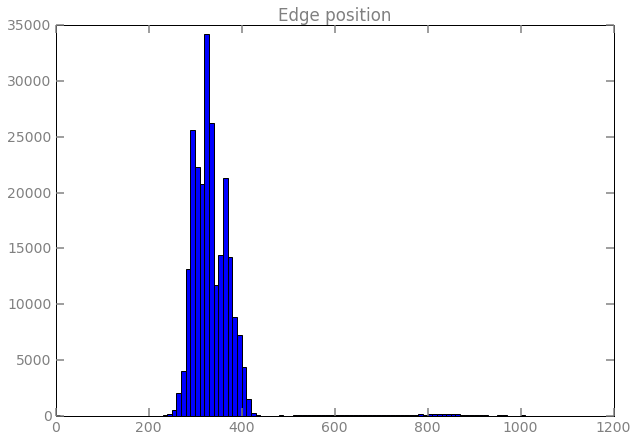

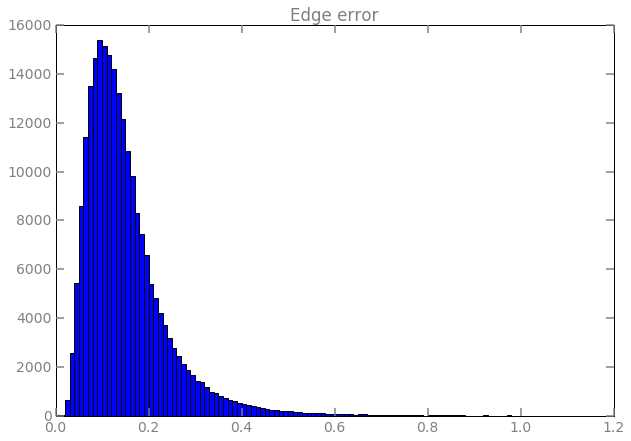

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in less
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in less


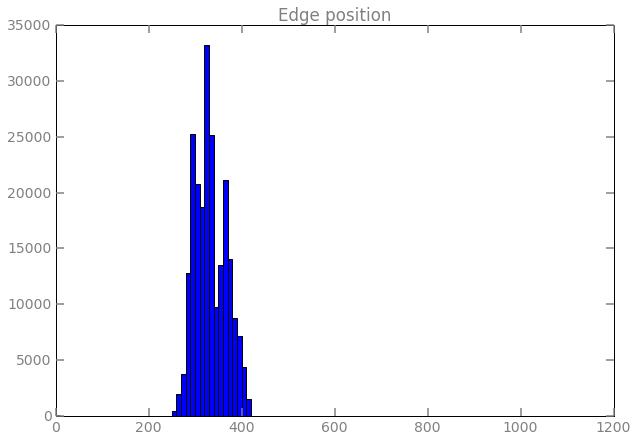

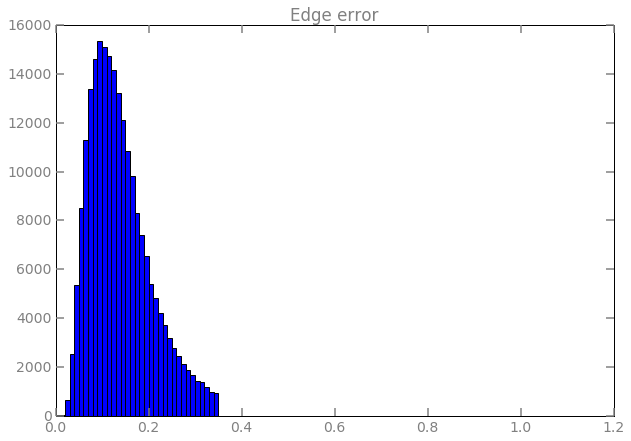

In [2]:
data = datastorage.read('vesp_run60_anaMPI.h5')
ttdata = datastorage.read('ttdata.h5')

t0 = 51.75
pixel_to_femtosecond = 0.0033444

mask = np.logical_and(~np.isnan(data.sig), ~np.isnan(data.I0))
mask &= ~np.isnan(ttdata['pix_edge_position'])
mask &= ~np.isinf(ttdata['pix_edge_error'])

plt.figure('edge_position')
plt.hist(ttdata['pix_edge_position'][mask], bins=np.arange(0,1200,10))
plt.title('Edge position')
plt.show()

plt.figure('edge_error')
plt.hist(ttdata['pix_edge_error'][mask], bins=np.arange(0,1.2,0.01))
plt.title('Edge error')
plt.show()

mask &= ~np.logical_or(ttdata['pix_edge_error']>0.35, ttdata['pix_edge_error']<0)
mask &= ~np.logical_or(ttdata['pix_edge_position']>420, ttdata['pix_edge_position']<250)

plt.figure('edge_position')
plt.hist(ttdata['pix_edge_position'][mask], bins=np.arange(0,1200,10))
plt.title('Edge position')
plt.show()

plt.figure('edge_error')
plt.hist(ttdata['pix_edge_error'][mask], bins=np.arange(0,1.2,0.01))
plt.title('Edge error')
plt.show()

In [3]:
dl = -((data.dl-t0)/0.15 + pixel_to_femtosecond*ttdata['pix_edge_position'])
dl = dl[mask]
I0 = data.I0[mask]*1000
I = data.sig[mask]
energy = data.ebeam.photon_energy[mask]
energyL3 = data.ebeam.L3_energy[mask]

print('Good data ratio: {:.2f}'.format(np.sum(mask)/mask.shape[0]))

Good data ratio: 0.85


### I0 filter

Numbers of shots before I0 filtering: (222204,)
Numbers of shots after I0 filtering: (161305,)


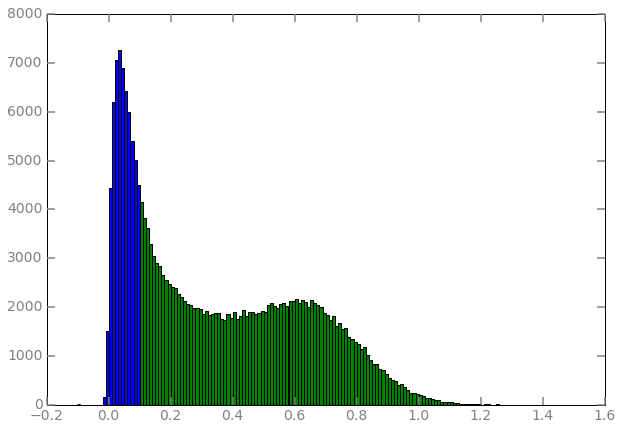

In [4]:
bins=np.arange(-0.1,1.5,0.01)
plt.hist(I0, bins=bins)
print('Numbers of shots before I0 filtering: {}'.format(I0.shape))

I0filt = 0.1
I0mask = I0>I0filt

dl = dl[I0mask]
I0 = I0[I0mask]
I = I[I0mask]
energy = energy[I0mask]
energyL3 = energyL3[I0mask]
print('Numbers of shots after I0 filtering: {}'.format(I0.shape))

plt.hist(I0, bins=bins)
plt.show()

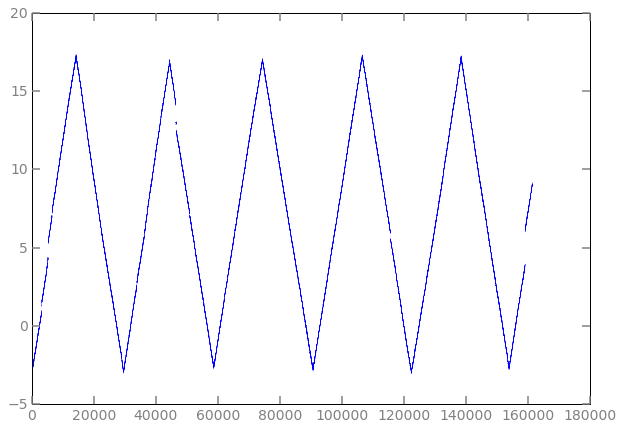

In [5]:
plt.figure()
plt.plot(dl,'.', markersize=0.1)
plt.show()

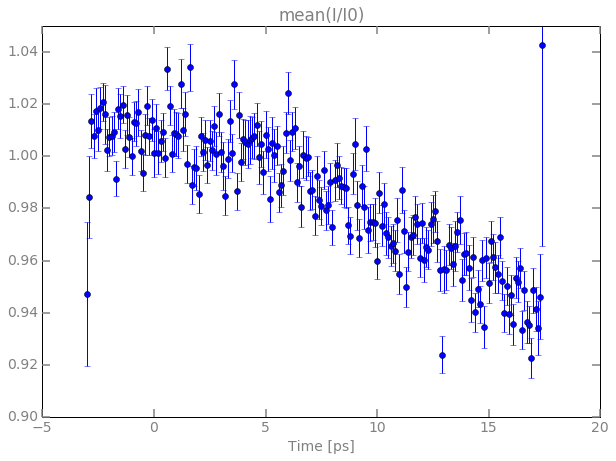

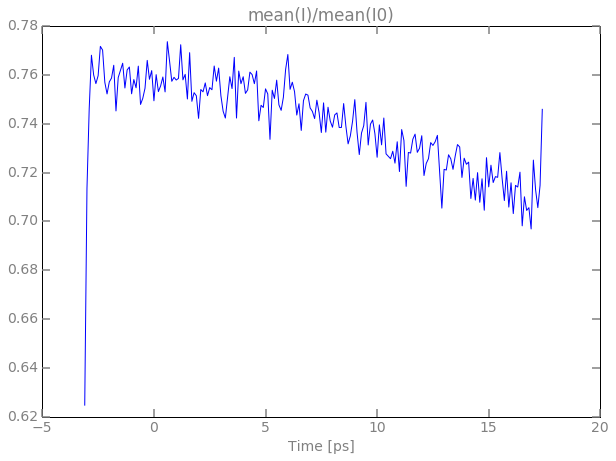

In [6]:
reload(ana)
data_tobin = {
    'dl' : dl,
    'I0' : I0,
    'I' : I,
    'Inorm' : I/I0,
    'energy' : energy,
    'energyL3' : energyL3
}

bins = np.arange(-5,20,0.1)
binned_data, bin_edges = ana.binData(data_tobin, bin_centers=bins, statkeys=['I0','I','Inorm'])


to_plot = 'Inorm'
temp = binned_data[to_plot+'_mean'][binned_data['dl']<0]
plt.figure()
plt.errorbar(binned_data['dl'], 
             binned_data[to_plot+'_mean']/np.mean(temp[~np.isnan(temp)]), 
             binned_data[to_plot+'_std']/np.sqrt(binned_data[to_plot+'_count']), marker='o', linestyle='None')
plt.xlabel('Time [ps]')
plt.ylim([0.9,1.05])
plt.title('mean(I/I0)')

plt.figure()
plt.plot(binned_data['dl'], binned_data['I_mean']/binned_data['I0_mean'])
plt.xlabel('Time [ps]')
plt.title('mean(I)/mean(I0)')
plt.show()